This notebook conduct dataset cleaning on CICIDS2017 in the following aspect:
* remove space before each feature names
* assign 0 for non-negative features when there is negative values
* drop zero variance columns (only have 1 unique value)
* remove inf, -inf, nan, and duplicate rows
* drop columns with identical values

However, two recent papers [1](#first), [2](#second) have been discussing that CIC-IDS-2017 and CSE-CIC-IDS-2018 have many errors throughout the dataset creation lifecycle, such as in attack orchestration, feature generation, documentation, and labeling.
* Attack orchestration errors: These are errors that occur during the execution of the attack scenarios on the network.
* Feature generation errors: These are errors that occur during the extraction of features from the network traffic using CICFlowMeter.
* Documentation errors: These are errors that occur during the description and explanation of the datasets and their components. 
* Labeling errors: These are errors that occur during the assignment of labels to the network flows based on their class or category.

[1](#first) have published their improved version of these two datasets [here](https://intrusion-detection.distrinet-research.be/CNS2022/Dataset_Download.html).

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import combinations, product

#sklearn
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler
from sklearn.metrics import precision_recall_curve, auc, roc_curve, recall_score, precision_score, f1_score

#graph
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Original CICIDS2017

In [2]:
dataset_csv_path = '/kaggle/input/cicids2017/MachineLearningCSV/MachineLearningCVE/'
csv_file_names = ['Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv', 
                  'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv', 
                  'Friday-WorkingHours-Morning.pcap_ISCX.csv', 
                  'Monday-WorkingHours.pcap_ISCX.csv', 
                  'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv', 
                  'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', 
                  'Tuesday-WorkingHours.pcap_ISCX.csv', 
                  'Wednesday-workingHours.pcap_ISCX.csv']

complete_paths = []
for csv_file_name in csv_file_names:
    complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

df = pd.concat(map(pd.read_csv, complete_paths), 
               ignore_index = True)

In [3]:
def clean_df(df):
    # Remove the space before each feature names
    df.columns = df.columns.str.strip()
    print('dataset shape', df.shape)

    # This set of feature should have >= 0 values
    num = df._get_numeric_data()
    num[num < 0] = 0

    zero_variance_cols = []
    for col in df.columns:
        if len(df[col].unique()) == 1:
            zero_variance_cols.append(col)
    df.drop(zero_variance_cols, axis = 1, inplace = True)
    print('zero variance columns', zero_variance_cols, 'dropped')
    print('shape after removing zero variance columns:', df.shape)

    df.replace([np.inf, -np.inf], np.nan, inplace = True)
    print(df.isna().any(axis = 1).sum(), 'rows dropped')
    df.dropna(inplace = True)
    print('shape after removing nan:', df.shape)

    # Drop duplicate rows
    df.drop_duplicates(inplace = True)
    print('shape after dropping duplicates:', df.shape)

    column_pairs = [(i, j) for i, j in combinations(df, 2) if df[i].equals(df[j])]
    ide_cols = []
    for column_pair in column_pairs:
        ide_cols.append(column_pair[1])
    df.drop(ide_cols, axis = 1, inplace = True)
    print('columns which have identical values', column_pairs, 'dropped')
    print('shape after removing identical value columns:', df.shape)
    return df
df = clean_df(df)

dataset shape (2830743, 79)
zero variance columns ['Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate'] dropped
shape after removing zero variance columns: (2830743, 71)
2867 rows dropped
shape after removing nan: (2827876, 71)
shape after dropping duplicates: (2520798, 71)
columns which have identical values [('Total Fwd Packets', 'Subflow Fwd Packets'), ('Total Backward Packets', 'Subflow Bwd Packets'), ('Fwd PSH Flags', 'SYN Flag Count'), ('Fwd URG Flags', 'CWE Flag Count'), ('Fwd Header Length', 'Fwd Header Length.1')] dropped
shape after removing identical value columns: (2520798, 66)


In [4]:
df['Label'].value_counts()

BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack � Brute Force         1470
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: Label, dtype: int64

# Improved CICIDS2017

In [5]:
dataset_csv_path = '/kaggle/input/improved-cicids2017-and-csecicids2018/CICIDS2017_improved'
csv_file_names = ['monday.csv', 
                  'tuesday.csv', 
                  'wednesday.csv', 
                  'thursday.csv', 
                  'friday.csv']

complete_paths = []
for csv_file_name in csv_file_names:
    complete_paths.append(os.path.join(dataset_csv_path, csv_file_name))

improved_df = pd.concat(map(pd.read_csv, complete_paths), 
                        ignore_index = True)

In [6]:
dropping_cols = ['id', 'Flow ID', 'Src IP', 'Src Port', 'Dst IP', 
                 'Dst Port', 'Timestamp']
improved_df = clean_df(improved_df)
improved_df.drop(dropping_cols, axis = 1, inplace = True)
improved_df['Label'].value_counts()

dataset shape (2099976, 91)
zero variance columns [] dropped
shape after removing zero variance columns: (2099976, 91)
5 rows dropped
shape after removing nan: (2099971, 91)
shape after dropping duplicates: (2099971, 91)
columns which have identical values [] dropped
shape after removing identical value columns: (2099971, 91)


BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                       45


In [7]:
improved_df['Label'].value_counts()

BENIGN                                    1582561
Portscan                                   159066
DoS Hulk                                   158468
DDoS                                        95144
Infiltration - Portscan                     71767
DoS GoldenEye                                7567
Botnet - Attempted                           4067
FTP-Patator                                  3972
DoS Slowloris                                3859
DoS Slowhttptest - Attempted                 3368
SSH-Patator                                  2961
DoS Slowloris - Attempted                    1847
DoS Slowhttptest                             1740
Web Attack - Brute Force - Attempted         1292
Botnet                                        736
Web Attack - XSS - Attempted                  655
DoS Hulk - Attempted                          581
DoS GoldenEye - Attempted                      80
Web Attack - Brute Force                       73
Infiltration - Attempted                       45


In [8]:
improved_df['Attempted Category'].value_counts()

0    2092837
1       4067
6       2804
5        138
4         75
3         27
2         23
Name: Attempted Category, dtype: int64

Although the flows of attempted attacks have malicious intents,they don't have anomaly effect on the system due to the following reasons [3](#third):
* Category 0 - No payload sent by attacker
* Category 1 - Port/System closed
* Category 2 - Attack Startup/Teardown Artefact
* Category 3 - No malicious payload
* Category 4 - Attack Artefact
* Category 5 - Attack Implemented Incorrectly
* Category 6 - Target System Unresponsive

For these kinds of attempted labels, we have a choice to treat them as benign or malicious.

In most cases of network intrusion detection, we process each flow separately, so the classifier can only see only flow at a time and doesn't know the context.

As a result, they are re-labeled as BENIGN [4](#fourth).

In [9]:
attepmted_labels = [s for s in improved_df['Label'].unique() if 'Attempted' in s]

improved_df.drop(['Attempted Category'], axis = 1, inplace = True)

improved_df.replace(attepmted_labels, 'BENIGN', inplace = True)
improved_df['Label'].value_counts()

BENIGN                        1594540
Portscan                       159066
DoS Hulk                       158468
DDoS                            95144
Infiltration - Portscan         71767
DoS GoldenEye                    7567
FTP-Patator                      3972
DoS Slowloris                    3859
SSH-Patator                      2961
DoS Slowhttptest                 1740
Botnet                            736
Web Attack - Brute Force           73
Infiltration                       36
Web Attack - XSS                   18
Web Attack - SQL Injection         13
Heartbleed                         11
Name: Label, dtype: int64

# 2D-PCA visualization

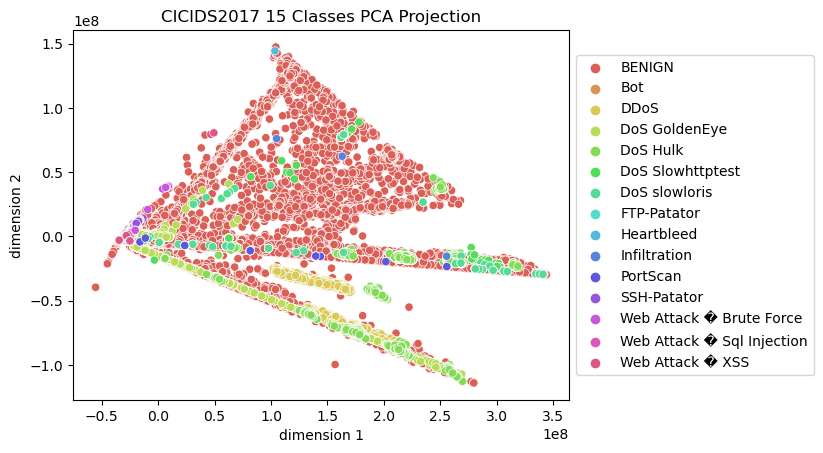

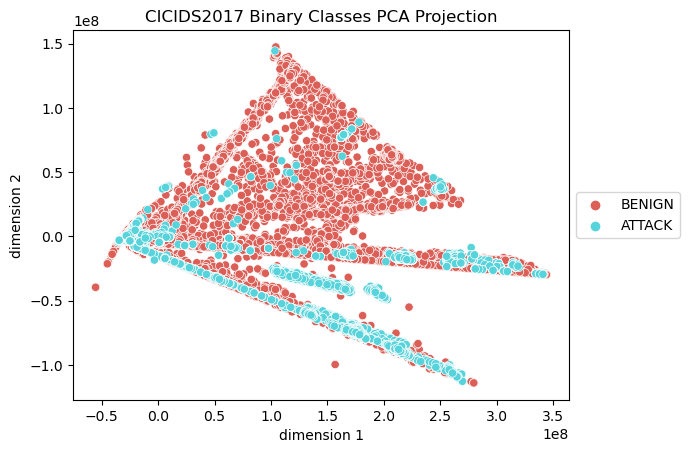

In [10]:
# https://stackoverflow.com/questions/43640952/how-to-subsample-a-pandas-dataframe-respecting-the-frequency-of-each-class
subsample_df = df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

pca_2_df = pd.DataFrame()
pca_2_df['Label'] = y
pca_2_df.loc[pca_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
pca_2_df['dimension 1'] = z[:, 0]
pca_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = pca_2_df).set(title = 'CICIDS2017 Binary Classes PCA Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

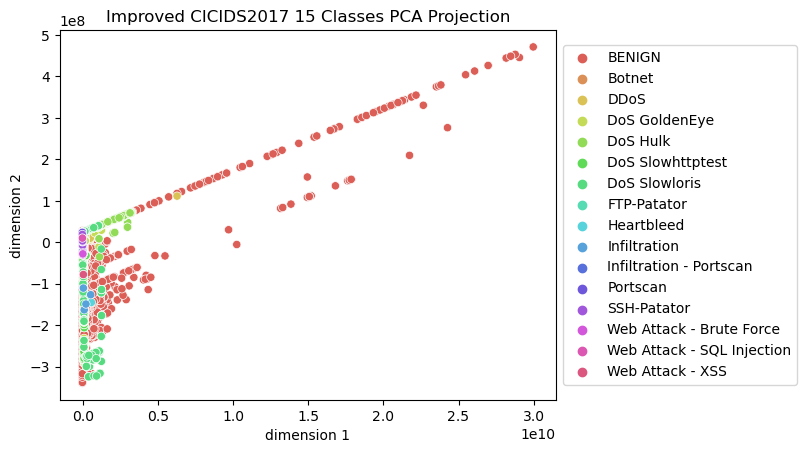

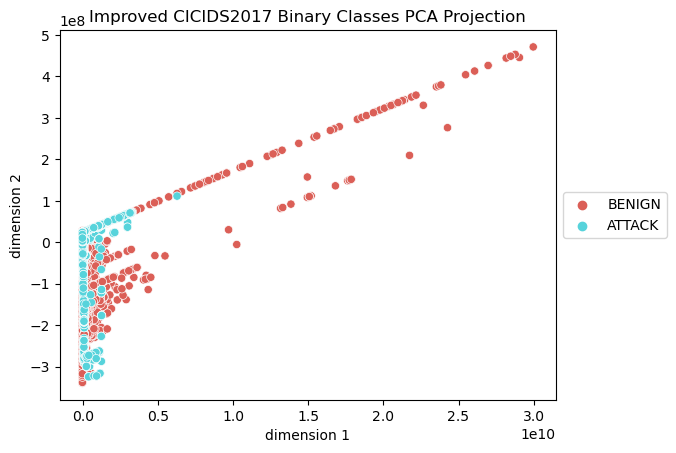

In [11]:
subsample_improved_df = improved_df.groupby('Label').apply(pd.DataFrame.sample, frac = 0.1).reset_index(drop = True)

X = subsample_improved_df.drop(['Label'], axis = 1)
y = subsample_improved_df['Label']

pca = PCA(n_components = 2, random_state = 0)
z = pca.fit_transform(X) 

pca_15_df = pd.DataFrame()
pca_15_df['Label'] = y
pca_15_df['dimension 1'] = z[:, 0]
pca_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_15_df.Label,
                palette = sns.color_palette('hls', len(pca_15_df.Label.value_counts())),
                data = pca_15_df).set(title = 'Improved CICIDS2017 15 Classes PCA Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

pca_2_df = pd.DataFrame()
pca_2_df['Label'] = y
pca_2_df.loc[pca_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
pca_2_df['dimension 1'] = z[:, 0]
pca_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = pca_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = pca_2_df).set(title = 'Improved CICIDS2017 Binary Classes PCA Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

# 2D-TSNE visualization

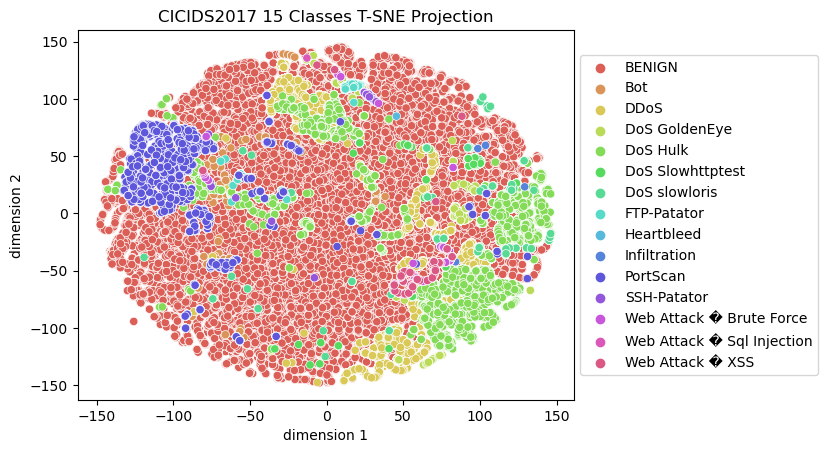

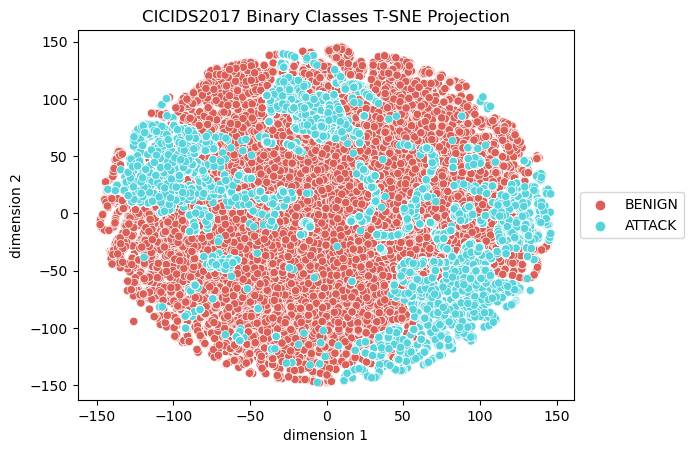

CPU times: user 2h 19min 59s, sys: 2min 8s, total: 2h 22min 8s
Wall time: 45min 36s


In [12]:
%%time
X = subsample_df.drop(['Label'], axis = 1)
y = subsample_df['Label']

tsne = TSNE(n_components = 2, n_jobs = -1, verbose = 0, random_state = 0)
z = tsne.fit_transform(X) 

tsne_15_df = pd.DataFrame()
tsne_15_df['Label'] = y
tsne_15_df['dimension 1'] = z[:, 0]
tsne_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_15_df.Label,
                palette = sns.color_palette('hls', len(tsne_15_df.Label.value_counts())),
                data = tsne_15_df).set(title = 'CICIDS2017 15 Classes T-SNE Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

tsne_2_df = pd.DataFrame()
tsne_2_df['Label'] = y
tsne_2_df.loc[tsne_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
tsne_2_df['dimension 1'] = z[:, 0]
tsne_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = tsne_2_df).set(title = 'CICIDS2017 Binary Classes T-SNE Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

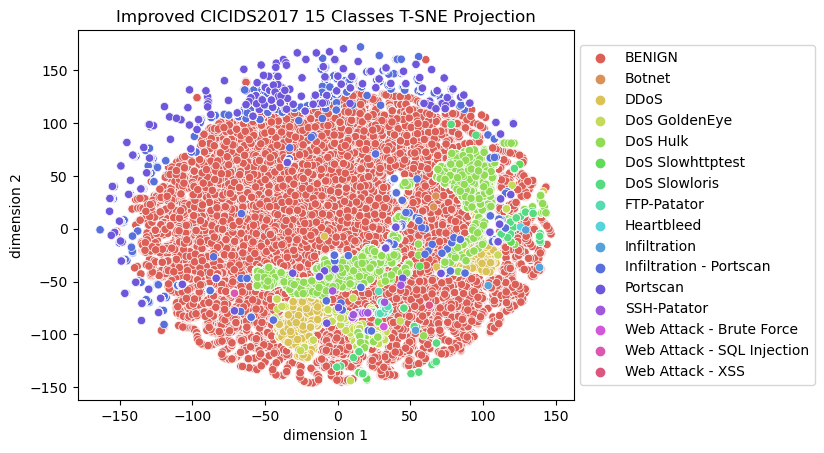

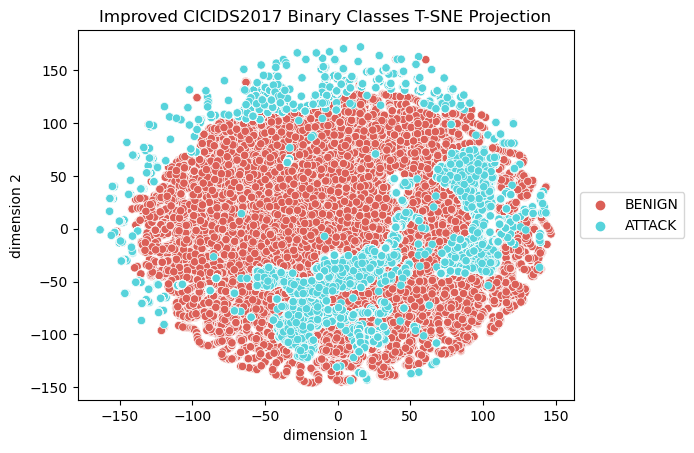

CPU times: user 1h 52min 24s, sys: 1min 41s, total: 1h 54min 6s
Wall time: 37min 41s


In [13]:
%%time
X = subsample_improved_df.drop(['Label'], axis = 1)
y = subsample_improved_df['Label']

tsne = TSNE(n_components = 2, n_jobs = -1, verbose = 0, random_state = 0)
z = tsne.fit_transform(X) 

tsne_15_df = pd.DataFrame()
tsne_15_df['Label'] = y
tsne_15_df['dimension 1'] = z[:, 0]
tsne_15_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_15_df.Label,
                palette = sns.color_palette('hls', len(tsne_15_df.Label.value_counts())),
                data = tsne_15_df).set(title = 'Improved CICIDS2017 15 Classes T-SNE Projection')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

tsne_2_df = pd.DataFrame()
tsne_2_df['Label'] = y
tsne_2_df.loc[tsne_2_df.Label != 'BENIGN', 'Label'] = 'ATTACK'
tsne_2_df['dimension 1'] = z[:, 0]
tsne_2_df['dimension 2'] = z[:, 1]

sns.scatterplot(x = 'dimension 1', y = 'dimension 2', 
                hue = tsne_2_df.Label,
                palette = sns.color_palette('hls', 2),
                data = tsne_2_df).set(title = 'Improved CICIDS2017 Binary Classes T-SNE Projection') 
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5)) 
plt.show()

# Train, validation, and test split [6](#sixth)

In [14]:
all_malicious = improved_df[improved_df.Label != 'BENIGN']
all_benign = improved_df[improved_df.Label == 'BENIGN']
benign_1M = all_benign.sample(n = 1000000, random_state = 0)

train_size = 500000
test_size = 500000
validation_perc = 0.15

# benign trainin and testing
Y = benign_1M['Label'].map(lambda x: 1 if (x == 'BENIGN') else -1)
labels = benign_1M['Label']

X_train, X_test, y_train, y_test = train_test_split(benign_1M.drop(columns = ['Label']),
                                                    Y,
                                                    train_size = train_size, 
                                                    test_size = test_size, 
                                                    shuffle = True, 
                                                    stratify = Y, 
                                                    random_state = 0)
train_labels, test_labels = labels.loc[y_train.index], labels.loc[y_test.index]

# validation and testing
X_mal = all_malicious.drop(columns = ['Label'])
y_mal = all_malicious['Label'].map(lambda x: 1 if (x == 'Benign') else -1)
labels_mal = all_malicious['Label']

X_test = pd.concat([X_test, X_mal])
y_test = pd.concat([y_test, y_mal])
test_labels = pd.concat([test_labels, labels_mal])

X_val, X_t, y_val, y_t, label_val, label_t = train_test_split(X_test, 
                                                              y_test, 
                                                              test_labels, 
                                                              train_size = validation_perc, 
                                                              random_state = 0, 
                                                              stratify = test_labels, 
                                                              shuffle = True)

print("***** Train Data *****")
print(train_labels.value_counts())
print("***** Validation Data *****")
print(label_val.value_counts())
print("***** Test Data *****")
print(label_t.value_counts())

***** Train Data *****
BENIGN    500000
Name: Label, dtype: int64
***** Validation Data *****
BENIGN                        75000
Portscan                      23860
DoS Hulk                      23770
DDoS                          14271
Infiltration - Portscan       10765
DoS GoldenEye                  1135
FTP-Patator                     596
DoS Slowloris                   579
SSH-Patator                     444
DoS Slowhttptest                261
Botnet                          110
Web Attack - Brute Force         11
Infiltration                      5
Web Attack - XSS                  3
Heartbleed                        2
Web Attack - SQL Injection        2
Name: Label, dtype: int64
***** Test Data *****
BENIGN                        425000
Portscan                      135206
DoS Hulk                      134698
DDoS                           80873
Infiltration - Portscan        61002
DoS GoldenEye                   6432
FTP-Patator                     3376
DoS Slowloris          

# Anomaly score and result evaluation [6](#sixth)

In [15]:
def anomaly_scores(original, transformed):
    sse = np.sum((original - transformed) ** 2, axis = 1) # sum of squared errors
    return sse

def evaluate_results(y_true, score):
    precision, recall, threshold = precision_recall_curve(y_true, score, pos_label = -1)
    au_precision_recall = auc(recall, precision)
    results = pd.DataFrame({'precision': precision, 'recall': recall})
    results['f1'] = 2 * precision * recall / (precision + recall)
    max_index = results['f1'].idxmax()
    best = results.loc[results['f1'].idxmax()]
    best['threshold'] = threshold[max_index]
    best['au_precision_recall'] = au_precision_recall
    fpr, tpr, thresholds = roc_curve(y_true, score, pos_label = -1)
    best['auroc'] = auc(fpr, tpr)
    return best

def evaluate_predictions(y_true, y_pred):
    results = {}
    results['precision'] = precision_score(y_true, y_pred, pos_label = -1, zero_division = 0)
    results['recall'] = recall_score(y_true, y_pred, pos_label = -1, zero_division = 0)
    results['f1'] = f1_score(y_true, y_pred, pos_label = -1, zero_division = 0)
    return results

def evaluate_test_data(y_true, score, threshold):
    y_pred = np.array([1 if score < threshold else -1 for score in score])
    results = evaluate_predictions(y_true, y_pred)
    precision, recall, threshold = precision_recall_curve(y_true, score, pos_label = -1)
    results['au_precision_recall'] = auc(recall, precision)
    fpr, tpr, thresholds = roc_curve(y_true, score, pos_label = -1)
    results['auroc'] = auc(fpr, tpr)
    return results

def pca_classifier(scaler, pca, threshold):
    def clf(X):
        x = scaler.transform(X)
        X_pca = pca.transform(x)
        X_pca_inv = pca.inverse_transform(X_pca)
        score = anomaly_scores(x, X_pca_inv)
        return np.array([1 if score < threshold else -1 for score in score])
    return clf

# PCA intrusion detection [5](#fifth), [6](#sixth)

## Preprocess with scalar [6](#sixth)

## Hyper-parameter tuning [6](#sixth)

In [16]:
%%time

import tqdm

input_dim = X_train.shape[1]

params = {
    'scalers': [StandardScaler(), 
                RobustScaler(quantile_range = (25, 75)), 
                QuantileTransformer(output_distribution = 'normal'), 
                MinMaxScaler(feature_range=(0, 1), copy = True)],
    'n_components': list(range(input_dim)),
}

best_scaler = None
best_pca = None
best_score = None
index = 0
results = []

for (scaler, n_components) in tqdm.tqdm(list(product(params['scalers'], params['n_components']))):
    # print('Scalar', scaler)
    x_train = scaler.fit_transform(X_train)
    x_val = scaler.transform(X_val)
    
    # print('Training number of components', n_components, 'PCA', end = '')
    n_components = 64
    pca = PCA(n_components = n_components, 
                copy = True, 
                whiten = False, 
                svd_solver = 'auto', 
                tol = 0.0, 
                iterated_power = 'auto', 
                random_state = 0)
    pca.fit(x_train)
    X_val_pca = pca.transform(x_val)
    X_val_pca_inv = pca.inverse_transform(X_val_pca)
    val_score = anomaly_scores(x_val, X_val_pca_inv)
    val_metrics = evaluate_results(y_val, val_score)
    val_metrics['n_components'] = n_components
    val_metrics['scaler'] = scaler
    val_metrics['index'] = index
    results.append(val_metrics)
    # print('validation auroc', val_metrics['auroc'])
    
    index += 1
    
    if best_score is None or val_metrics['auroc'] > best_score['auroc']:
        best_scaler = scaler
        best_pca = pca
        best_score = val_metrics


100%|██████████| 328/328 [1:25:08<00:00, 15.57s/it]

CPU times: user 2h 49min 5s, sys: 47min 5s, total: 3h 36min 11s
Wall time: 1h 25min 8s


In [17]:
print('Best scaler', best_score['scaler'], 'Best number of components', best_score['n_components'])
x_t = best_scaler.transform(X_t)
X_t_pca = best_pca.transform(x_t)
X_t_pca_inv = best_pca.inverse_transform(X_t_pca)
test_score = anomaly_scores(x_t, X_t_pca_inv)

print('Test performance on all attacks')
pprint(evaluate_test_data(y_t, test_score, best_score.threshold))

Best scaler QuantileTransformer(output_distribution='normal') Best number of components 64.0
Test performance on all attacks
{'au_precision_recall': 0.9092582664921672,
 'auroc': 0.9216302073077675,
 'f1': 0.853774877284716,
 'precision': 0.809609469233755,
 'recall': 0.9030368909982612}


In [18]:
df = pd.DataFrame({'label_t': label_t, 'y_test': y_t, 'test_score': test_score})
test_df = df[(df.label_t == 'DoS Slowloris') | (df.label_t == 'DoS Slowhttptest') | (df.label_t == 'BENIGN')]

print('Test performance on DoS Slowloris and Slowhttptest')
pprint(evaluate_test_data(test_df.y_test.tolist(), test_df.test_score.tolist(), best_score.threshold))

Test performance on DoS Slowloris and Slowhttptest
{'au_precision_recall': 0.1842091475787321,
 'auroc': 0.9668418906591844,
 'f1': 0.09437501861097601,
 'precision': 0.04952702421135975,
 'recall': 0.9989493591090566}


In [19]:
for label in [s for s in improved_df['Label'].unique() if s != 'BENIGN']:
    test_df = df[(df.label_t == label) | (df.label_t == 'BENIGN')]
    
    print('Test performance on', label)
    pprint(evaluate_test_data(test_df.y_test.tolist(), test_df.test_score.tolist(), best_score.threshold))

Test performance on FTP-Patator
{'au_precision_recall': 0.023744121871048768,
 'auroc': 0.841853185809869,
 'f1': 0.06878954888752806,
 'precision': 0.03562217242399898,
 'recall': 0.9982227488151659}
Test performance on SSH-Patator
{'au_precision_recall': 0.007302431663593303,
 'auroc': 0.60849993876931,
 'f1': 0.000575828019364883,
 'precision': 0.0002958547462771611,
 'recall': 0.010727056019070322}
Test performance on DoS Slowloris
{'au_precision_recall': 0.1623154495409992,
 'auroc': 0.9729041334289814,
 'f1': 0.06704024869109948,
 'precision': 0.03468342644320298,
 'recall': 0.999390243902439}
Test performance on DoS Slowhttptest
{'au_precision_recall': 0.04441064695310847,
 'auroc': 0.9533975659229209,
 'f1': 0.031341239422862543,
 'precision': 0.015920612663143135,
 'recall': 0.9979716024340771}
Test performance on DoS Hulk
{'au_precision_recall': 0.7609364448341966,
 'auroc': 0.9245216065743584,
 'f1': 0.7147619318505034,
 'precision': 0.5793380732379819,
 'recall': 0.93281266

# SHAP explainability

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 8547it [1:51:14,  1.28it/s]


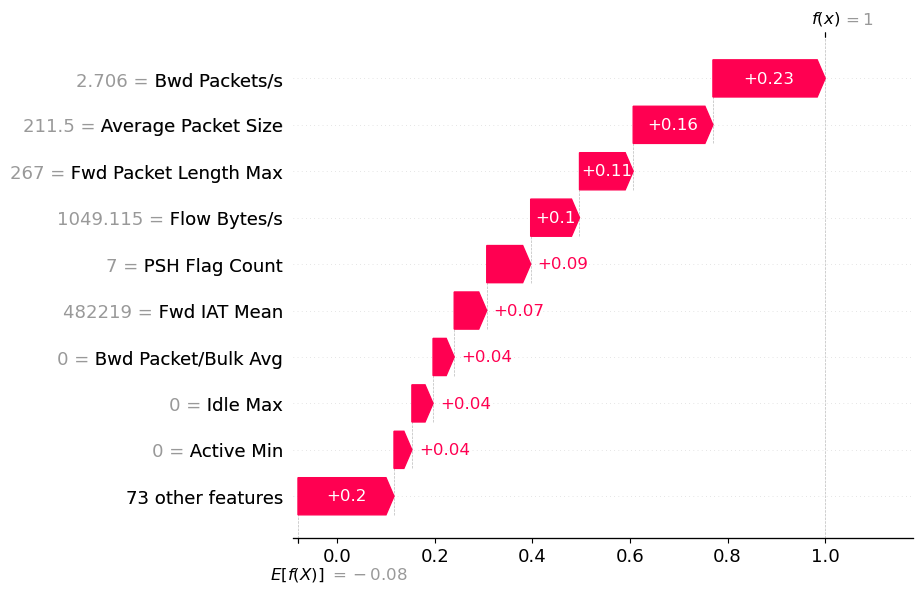

In [20]:
import shap

subsample_X_t = pd.DataFrame.sample(X_t, frac = 0.01).reset_index(drop = True)

# explain the model's predictions using SHAP
explainer = shap.Explainer(pca_classifier(best_scaler, best_pca, best_score.threshold), 
                           masker = shap.maskers.Independent(data = subsample_X_t))
shap_values = explainer(subsample_X_t)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


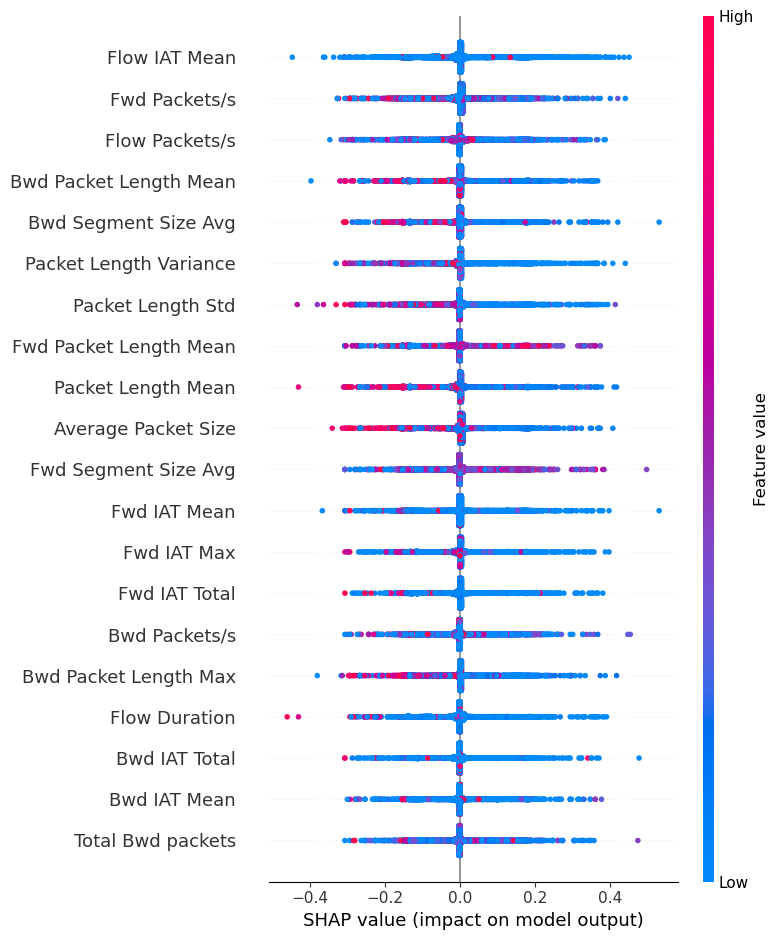

In [21]:
shap.summary_plot(shap_values, subsample_X_t)

The figure layout has changed to tight


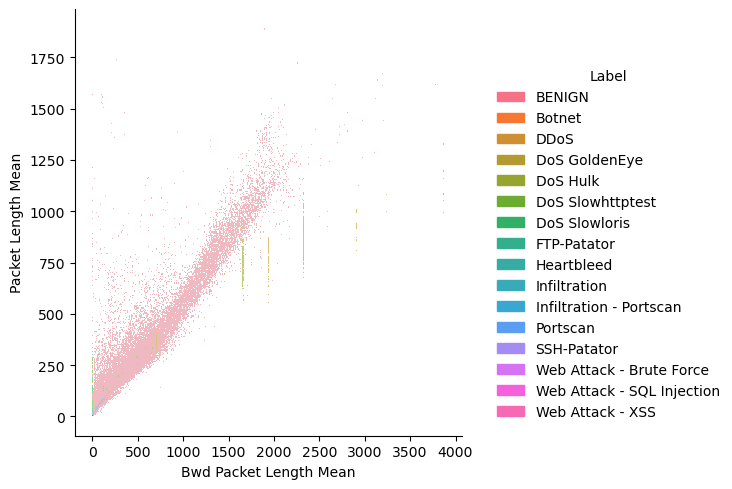

In [22]:
sns.displot(
    data = subsample_improved_df,
    x = 'Bwd Packet Length Mean', y = 'Packet Length Mean', hue = 'Label',
)
# Bwd Segment Size Avg, Subflow Bwd Bytes, Protocol, Fwd Packet Length Mean

The figure layout has changed to tight


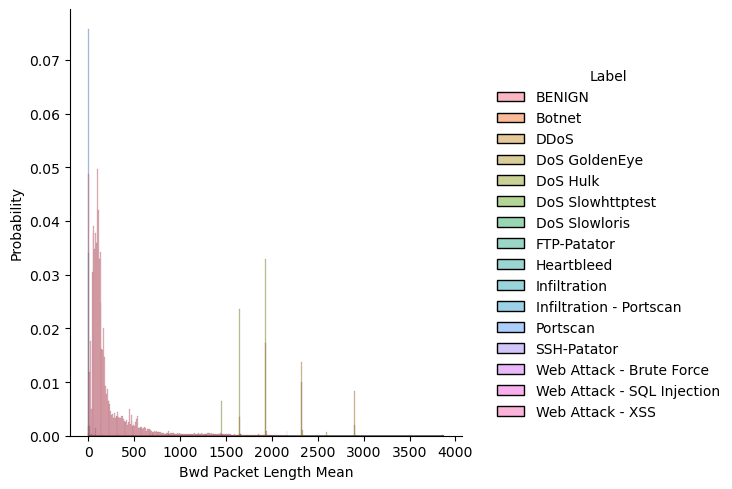

In [23]:
sns.displot(subsample_improved_df, x = 'Bwd Packet Length Mean', hue = 'Label', stat = 'probability')#, kind = 'kde')

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
The figure layout has changed to tight


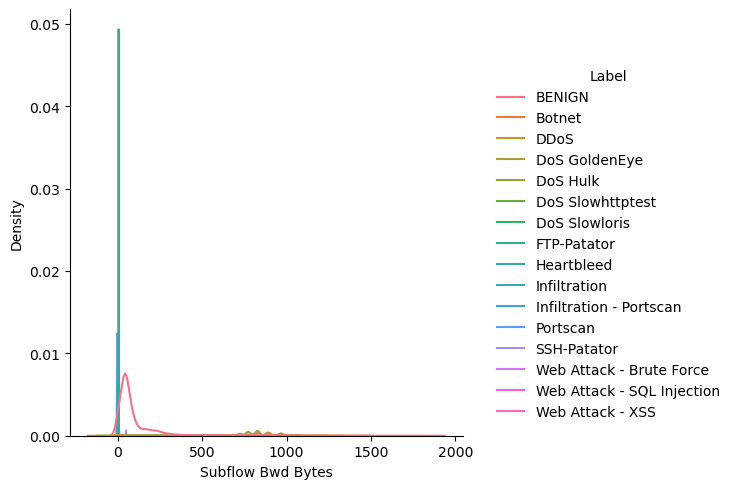

In [24]:
sns.displot(subsample_improved_df, x = 'Subflow Bwd Bytes', hue = 'Label', kind = 'kde')

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
The figure layout has changed to tight


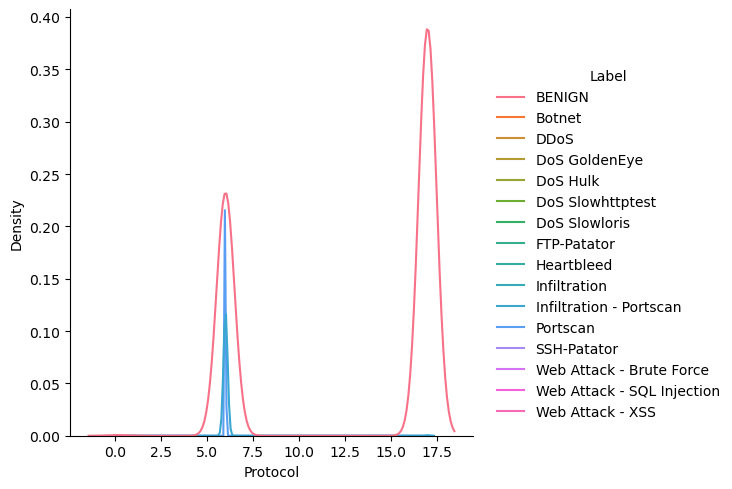

In [25]:
sns.displot(subsample_improved_df, x = 'Protocol', hue = 'Label', kind = 'kde')

In [26]:
improved_df.to_csv('cleaned_improved_cicids2017.csv', encoding = 'utf-8', index = False)

# Reference
1. <a id='first'></a>[Liu, Lisa, et al. "Error prevalence in nids datasets: A case study on cic-ids-2017 and cse-cic-ids-2018." 2022 IEEE Conference on Communications and Network Security (CNS). IEEE, 2022.](https://ieeexplore.ieee.org/abstract/document/9947235)
2. <a id='second'></a>[Lanvin, Maxime, et al. "Errors in the CICIDS2017 dataset and the significant differences in detection performances it makes." International Conference on Risks and Security of Internet and Systems. Cham: Springer Nature Switzerland, 2022.](https://link.springer.com/chapter/10.1007/978-3-031-31108-6_2)
3. <a id='third'></a>[Improved CIC-IDS 2017 Documentation](https://intrusion-detection.distrinet-research.be/CNS2022/CICIDS2017.html)
4. <a id='fourth'></a>[Error Prevalence in NIDS datasets: A Case Study on CIC-IDS-2017 and CSE-CIC-IDS-2018 (G. Engelen)](https://www.youtube.com/watch?v=sJvZKhw3lYo)
5. <a id='fifth'></a>Verkerken, Miel, et al. "Towards model generalization for intrusion detection: Unsupervised machine learning techniques." Journal of Network and Systems Management 30 (2022): 1-25.
6. <a id='sixth'></a>[CIC-IDS-2018](https://gitlab.ilabt.imec.be/mverkerk/cic-ids-2018)
7. Yang, Li, et al. "LCCDE: A decision-based ensemble framework for intrusion detection in the internet of vehicles." GLOBECOM 2022-2022 IEEE Global Communications Conference. IEEE, 2022.
8. [TSNE Visualization Example in Python](https://www.datatechnotes.com/2020/11/tsne-visualization-example-in-python.html)
9. [Multicore t-SNE](https://github.com/DmitryUlyanov/Multicore-TSNE)
10. [sklearn.manifold.TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
11. [What do maskers really do in SHAP package and fit them to train or test?](https://stackoverflow.com/questions/66560839/what-do-maskers-really-do-in-shap-package-and-fit-them-to-train-or-test)
12. [Python Statistics Fundamentals: How to Describe Your Data](https://realpython.com/python-statistics/)